In [61]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from imutils.perspective import four_point_transform

In [62]:
def show_images(titles, images, wait=True):
    """Display multiple images with one line of code"""

    for (title, image) in zip(titles, images):
        plt.title(title)
        plt.imshow(image)
        plt.axis("off")
        plt.show()

    if wait:
        cv2.waitKey(0)
        cv2.destroyAllWindows()

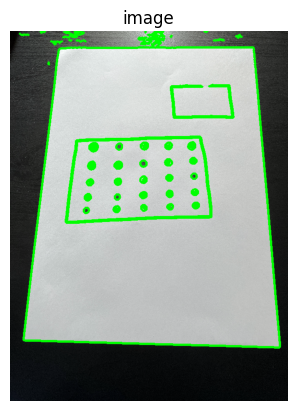

In [63]:
height = 800
width = 600
green = (0, 255, 0) # green color
red = (0, 0, 255) # red color
white = (255, 255, 255) # white color
questions = 5
answers = 5
correct_ans = [0, 1, 1, 3, 4]

img = cv2.imread('/content/Image20240803160225.jpg')
img = cv2.resize(img, (width, height))
img_copy = img.copy() # for display purposes
img_copy1 = img.copy() # for display purposes

gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur_img = cv2.GaussianBlur(gray_img, (5, 5), 0)
edge_img = cv2.Canny(blur_img, 50, 100) # adjust with your images

# find the contours in the image
contours, _ = cv2.findContours(edge_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

# draw the contours
cv2.drawContours(img, contours, -1, green, 3)
show_images(['image'], [img]) # helper function in helper.py file

In [64]:
def get_rect_cnts(contours):
    rect_cnts = []
    for cnt in contours:
        # approximate the contour
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
        # if the approximated contour is a rectangle ...
        if len(approx) == 4:
            # append it to our list
            rect_cnts.append(approx)
    # sort the contours from biggest to smallest
    rect_cnts = sorted(rect_cnts, key=cv2.contourArea, reverse=True)

    return rect_cnts

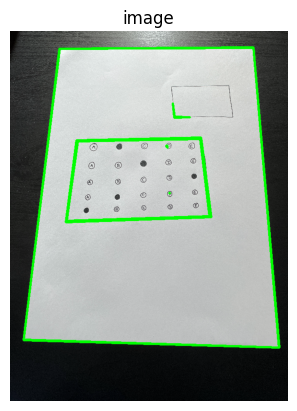

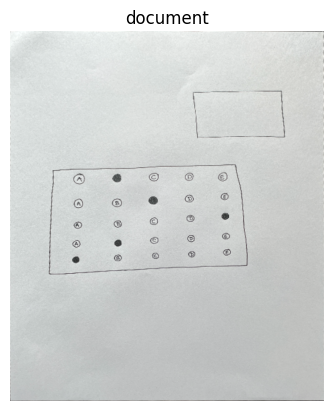

In [65]:
rect_cnts = get_rect_cnts(contours)
# warp perspective to get the top-down view of the document
document = four_point_transform(img_copy, rect_cnts[0].reshape(4, 2))
doc_copy = document.copy()  # for display purposes
doc_copy1 = document.copy() # for display purposes

cv2.drawContours(img_copy, rect_cnts, -1, green, 3)
# helper function in helper.py file
show_images(['image', 'document'], [img_copy, document])

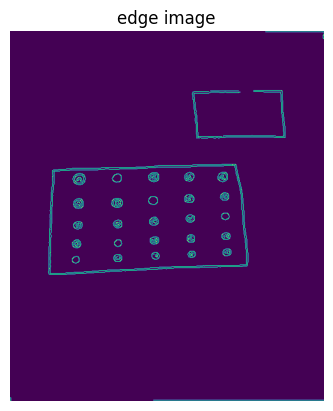

9
[array([[[397, 235]],

       [[ 74, 245]],

       [[ 68, 427]],

       [[416, 413]]], dtype=int32), array([[[349, 106]],

       [[320, 109]],

       [[328, 188]],

       [[320, 109]]], dtype=int32)]


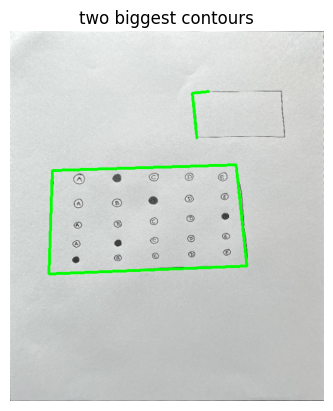

In [66]:
########################################################################
# Find the Two Biggest Contours on the Document
########################################################################

# find contours on the document
gray_doc = cv2.cvtColor(document, cv2.COLOR_BGR2GRAY)
blur_doc = cv2.GaussianBlur(gray_doc, (3, 3), 0)
edge_doc = cv2.Canny(blur_doc, 70, 150)
show_images(['edge image'], [edge_doc])
contours, _ = cv2.findContours(edge_doc, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))

rect_cnts = get_rect_cnts(contours)
print(rect_cnts)
# contours of the questions
biggest_cnt = rect_cnts[0]
# contours of the grade
grade_cnt = rect_cnts[1]

# draw the two biggest contours, which are the
# contour of the questions and the contour of the grade
cv2.drawContours(document, rect_cnts[:2], -1, green, 3)
show_images(['two biggest contours'], [document])

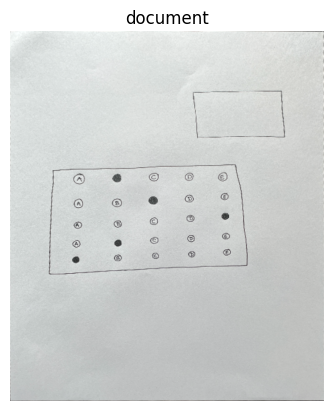

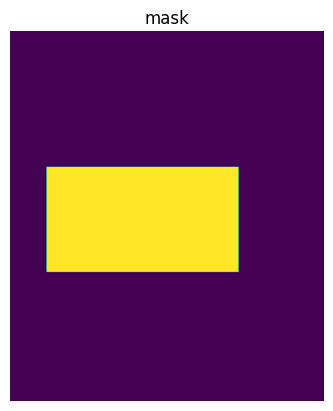

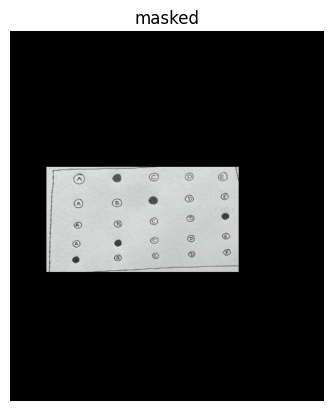

[[[222 227 226]
  [221 226 225]
  [218 222 221]
  ...
  [197 200 199]
  [212 214 213]
  [212 214 213]]

 [[219 224 223]
  [215 220 219]
  [212 217 216]
  ...
  [155 154 154]
  [210 212 211]
  [211 214 212]]

 [[218 223 222]
  [213 218 217]
  [208 213 212]
  ...
  [165 163 164]
  [210 213 211]
  [208 212 209]]

 ...

 [[202 207 206]
  [197 202 201]
  [200 205 204]
  ...
  [200 202 202]
  [199 201 201]
  [198 200 200]]

 [[206 211 210]
  [210 215 214]
  [204 209 208]
  ...
  [198 200 200]
  [201 203 203]
  [199 201 201]]

 [[201 206 205]
  [204 209 208]
  [201 206 205]
  ...
  [198 200 200]
  [205 207 207]
  [199 201 201]]] 401 239 64 423


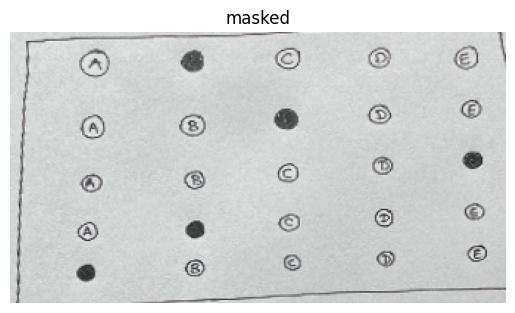

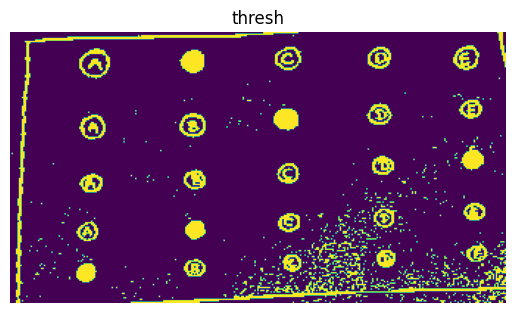

In [67]:
########################################################################
# Mask Everything in the Document Except the Area of the Biggest Contour
########################################################################

# cooredinates of the biggest contour
# I added 4 pixels to x and y, and removed 4 pixels from x_W and y_H to make
# sure we are inside the contour and not take the border of the biggest contour
x, y = biggest_cnt[0][0][0] + 4, biggest_cnt[0][0][1] + 4
x_W, y_H = biggest_cnt[2][0][0] - 4, biggest_cnt[2][0][1] - 4

# create a black image with the same dimension as the document
mask =  np.zeros((document.shape[0], document.shape[1]), np.uint8)
# we create a white rectangle in the region of the biggest contour
cv2.rectangle(mask, (x, y), (x_W, y_H), white, -1)
masked = cv2.bitwise_and(doc_copy, doc_copy, mask=mask)

show_images(['document', 'mask', 'masked'], [doc_copy, mask, masked])

# take only the region of the biggest contour
masked = masked[y:y_H, x_W:x]
print(masked, x, y, x_W, y_H)
gray = cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)

show_images(['masked', 'thresh'], [masked, thresh])


In [68]:
########################################################################
# Split the Area of the Biggest Contour
########################################################################

# split the thresholded image into boxes
def split_image(image):
    # make the number of rows and columns
    # a multiple of 5 (questions = answers = 5)
    r = len(image) // questions * questions
    c = len(image[0]) // answers * answers
    image = image[:r, :c]
    # split the image horizontally (row-wise)
    rows = np.vsplit(image, questions)
    boxes = []
    for row in rows:
        # split each row vertically (column-wise)
        cols = np.hsplit(row, answers)
        for box in cols:
            boxes.append(box)
    return boxes

boxes = split_image(thresh)


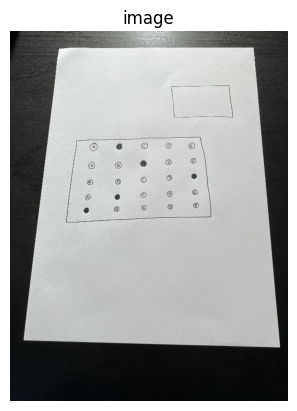

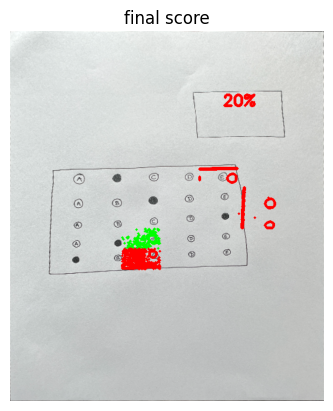

In [69]:
########################################################################
# Start Grading the Document
########################################################################

score = 0

# loop over the questions
for i in range(0, questions):
    user_answer = None

    # loop over the answers
    for j in range(answers):
        pixels = cv2.countNonZero(boxes[j + i * 5])
        # if the current answer has a larger number of
        # non-zero (white) pixels then the previous one
        # we update the `user_answer` variable
        if user_answer is None or pixels > user_answer[1]:
            user_answer = (j, pixels)

    # find the contours of the bubble that the user has filled
    cnt, _ = cv2.findContours(boxes[user_answer[0] + i * 5],
                                      cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # translate the coordinates of the contours
    # to their original place in the document
    for c in cnt:
        c[:, :, 0] += x + ((x_W - x) // 5) * user_answer[0]
        c[:, :, 1] += y + ((y_H - y) // 5) * i


    # if the user's answer is correct, we increase the score and draw
    # a green contour arround the bubble that the user has filled
    if correct_ans[i] == user_answer[0]:
        cv2.drawContours(doc_copy1, cnt, -1, [0,255,0], 3)
        score += 1
    # otherwise we draw a red contour
    else:
        cv2.drawContours(doc_copy1, cnt, -1, [255,0,0], 3)

score = (score / 5) * 100

# get the (x, y) coordinates of the grade contour.
# we add some pixels to make sure the text is inside the contour.
x_grade = grade_cnt[0][0][0] + 25
y_grade = grade_cnt[0][0][1] + 25
cv2.putText(doc_copy1, "{}%".format(int(score)),
            (x_grade, y_grade), cv2.FONT_HERSHEY_SIMPLEX, 0.9, [255,0,0], 3)

show_images(['image', 'final score'], [img_copy1, doc_copy1])